Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

[[9.819082, 57.131619], [9.822378, 57.077918], [9.908072, 57.106568], [9.819082, 57.131619]]
Point 0 =  9.908072
Ref_Point 0 =  9.819082
Point 1 =  57.077918
Ref_Point 1 =  57.131619
Point 1 - Ref_Point 1 =  -0.053701000000003773
Global2Local =  (5380.16622915858, 5977.9654861115305)
Number of grids in X =  649.4435139128179
Number of grids in Y =  721.6042675984365
Total number of grids =  468641.211203614
Point 0 =  9.819082
Ref_Point 0 =  9.819082
Point 1 =  57.131619
Ref_Point 1 =  57.131619
Point 1 - Ref_Point 1 =  0.0
Point 0 =  9.822378
Ref_Point 0 =  9.819082
Point 1 =  57.077918
Ref_Point 1 =  57.131619
Point 1 - Ref_Point 1 =  -0.053701000000003773
Point 0 =  9.908072
Ref_Point 0 =  9.819082
Point 1 =  57.106568
Ref_Point 1 =  57.131619
Point 1 - Ref_Point 1 =  -0.025050999999997714
Point 0 =  9.819082
Ref_Point 0 =  9.819082
Point 1 =  57.131619
Ref_Point 1 =  57.131619
Point 1 - Ref_Point 1 =  0.0
[[[   0    0]]

 [[ 200 5978]]

 [[5379 2789]]

 [[   0    0]]]


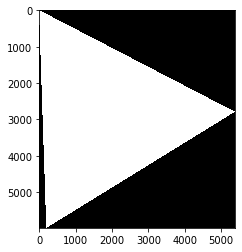

In [15]:
from ipyleaflet import *
from ipywidgets import Layout
import geojson
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt


url = "https://api.mapbox.com/styles/v1/bedaberner/ck1dsr3tg1oq11cqp1zw2oilc/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiYmVkYWJlcm5lciIsImEiOiJjazFkc3BheTEwYXhtM2NxcHY3c2k2MTl1In0.G5Pr0yi-ssOvkm-KO1aEAw"
provider = TileLayer(url=url, opacity=1)
defaultLayout=Layout(width='840px', height='840px')
m = Map(layers=(provider,),center=[57.0488, 9.9217], zoom=10, layout=defaultLayout,)

draw_control = DrawControl()
draw_control.polygon = {
    "shapeOptions": {
        "fillColor": "#6be5c3",
        "color": "#6be5c3",
        "fillOpacity": 0.5
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Oups!"
    },
    "allowIntersection": False
}

def global2local(point, ref_point):
    c_earth = 40075000
    print('Point 0 = ',point[0])
    print('Ref_Point 0 = ',ref_point[0])
    print('Point 1 = ',point[1])
    print('Ref_Point 1 = ',ref_point[1])
    print('Point 1 - Ref_Point 1 = ',point[1]-ref_point[1])
    
    dlat = ref_point[1] - point[1]
    dlon = point[0] - ref_point[0]
    
    dx = dlon * c_earth * math.cos((ref_point[1]+point[1]) * math.pi/360)/360
    dy = dlat * c_earth / 360
    return dx,dy
def create_waypoints(coordinates,cam_fov_deg,height,overlap):
    cam_fov = math.radians(cam_fov_deg/2)
    lat_max = coordinates[0][1]
    lat_min = coordinates[0][1]
    lon_max = coordinates[0][0]
    lon_min = coordinates[0][0]
    
    for coordinate in coordinates:
        if coordinate[0] > lon_max:
            lon_max = coordinate[0]
            
        elif coordinate[0] < lon_min:
            lon_min = coordinate[0]
            
        if coordinate[1] > lat_max:
            lat_max = coordinate[1]
            
        elif coordinate[1] < lat_min:
            lat_min = coordinate[1]
    
    dlat = lat_max - lat_min
    dlon = lon_max - lon_min
    
    c_earth = 40075000
    
    #dx = dlon * c_earth * math.cos((lat_max + lat_min) * math.pi/360)/360
    #dy = dlat * c_earth / 360
    
    #print('dx = ',dx)
    #print('dy = ',dy)
    Global2local = global2local((lon_max,lat_min),(lon_min,lat_max))
    dx = Global2local[0]
    dy = Global2local[1]
    print('Global2Local = ',Global2local)
        
    cell_size_x = math.tan(cam_fov)*height*overlap
    cell_size_y = math.tan(cam_fov)*height*overlap
    
    n_grids_x = dx/cell_size_x
    n_grids_y = dy/cell_size_y
    
    print('Number of grids in X = ',n_grids_x)
    print('Number of grids in Y = ',n_grids_y)
    
    n_grids_total = n_grids_x * n_grids_y
    print('Total number of grids = ',n_grids_total)
    
    map_array=np.zeros((math.ceil(dy),math.ceil(dx)))
    
    coordinates_rel=[]
    ref_point=(lon_min,lat_max)
    
    for coordinate in coordinates:
        coordinates_rel.append(np.ceil(global2local(coordinate,ref_point)).astype('int'))
        
    coord_rel_np=np.array(coordinates_rel) 
    
    pts=coord_rel_np.reshape((-1,1,2)) 
    print(pts)
        
    cv2.fillPoly(map_array,[pts],1)
    plt.imshow(map_array,cmap='gray')
    plt.show
    
    
        
        
    
    
    

def handle_draw(self, action, geo_json):
    print(geo_json['geometry']['coordinates'][0])

    f = open("field.geojson", "w")

    create_waypoints(geo_json['geometry']['coordinates'][0],45,40,0.5)
    f.write(geojson.dumps(geo_json))
    f.close()

draw_control.on_draw(handle_draw)

m.add_control(draw_control)

m

In [2]:
"""
pts = np.array([[10,5],[20,30],[70,20],[50,10]])
pts = pts.reshape((-1,1,2))
print(pts)"""

[[[10  5]]

 [[20 30]]

 [[70 20]]

 [[50 10]]]


In [11]:
"""
pts = np.array([[0,1],[0,4],[4,3]],)
pts = pts.reshape((-1,1,2))

a=np.zeros((5,5))
cv2.fillPoly(a,[pts],1)
print(a)
"""


[[0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0.]]
